In [1]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),

])

val_dataset = torchvision.datasets.DatasetFolder("Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

The key idea of CAM is to multiply the output of the last convolutional layer (BasicBlock 1 of layer 4) $A_k$ (consisting of k channels) with the parameters $w$ of the subsequent fully connected layer to compute an activation map $M$:
$$ M = \sum_k w_kA_k$$

To do so, we need to access this particular output of the trained resnet18.<br />
Let's recap the resnet architecture:

In [4]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
temp_model.children()

<generator object Module.children at 0x000001992BB09660>

In [6]:
list(temp_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [7]:
list(temp_model.children())[:-2]  # get all layers up to avgpool

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

Using **Sequential** from pytorch, we convert the list of layers back to a Sequential Model.


In [10]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [21]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1,1))
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_out_flattened)
        return pred, feature_map

In [23]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
    
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        
        print(avg_pool_output.shape)
        
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    

In [24]:
model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt", strict=False)
model.eval()

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [26]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape(512,49)
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7,7).cpu()
    return cam_img, torch.sigmoid(pred)

In [27]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224,224))[0]
    
    fig, axis = plt.subplots(1,2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred>0.5)

#### Demo

In [34]:
img = val_dataset[-32][0]   # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

torch.Size([1, 512, 1, 1])
torch.Size([512])


<IPython.core.display.Javascript object>


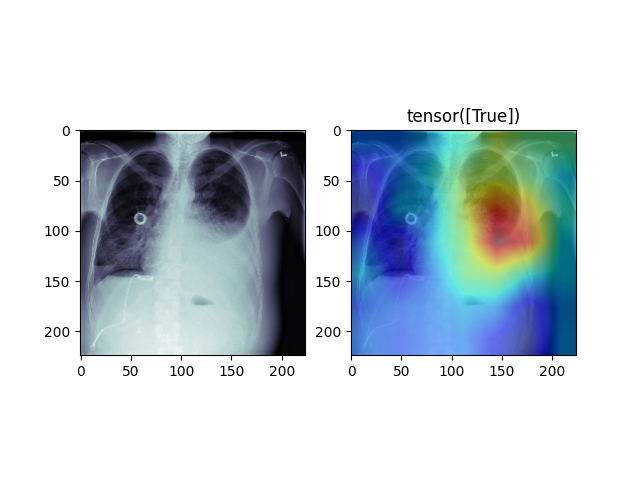

In [35]:
visualize(img, activation_map, pred)

The heatmap focuses on the area which shows signs of pneumonia